In [1]:
import gymnasium as gym
from replay_buffer import ReplayBuffer
import torch
import numpy as np

# Set seeds
seed = 23524
torch.manual_seed(seed)
np.random.seed(seed)

In [2]:
render = False
if render:
    env = gym.make('Pendulum-v1', g=9.81, render_mode="human")
else:
    env = gym.make('Pendulum-v1', g=9.81)
max_episodes = 1000
max_steps = 200

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
buf_dim = int(max_episodes*max_steps)

# create training set
seed = 1
training_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=buf_dim)

for episode in range(max_episodes):
    observation, info = env.reset()
    for steps in range(max_steps+1):
        action = env.action_space.sample()  # agent policy that uses the observation and info
        next_observation, reward, terminated, truncated, info = env.step(action)

        done = terminated or truncated
        training_buffer.store(observation, action, reward, next_observation, done)

        env.render()

        observation = next_observation

        if done:
            done = False
            break

print("Finished creating the training set")

/home/nicolo/Documents/Sparsifying-Parametric-Models-with-L0/venv/lib/python3.10/site-packages/gymnasium/envs/classic_control/pendulum.py:173: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("Pendulum-v1", render_mode="rgb_array")
  gym.logger.warn(


Finished creating the training set


In [3]:
# create test set
max_episodes_test = 100
buf_dim = int(max_episodes*max_steps)

seed = 7
testing_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=buf_dim)

for episode in range(max_episodes_test):
    observation, info = env.reset()
    for steps in range(max_steps + 1):
        action = env.action_space.sample()  # agent policy that uses the observation and info
        next_observation, reward, terminated, truncated, info = env.step(action)

        done = terminated or truncated
        testing_buffer.store(observation, action, reward, next_observation, done)

        env.render()

        observation = next_observation

        if done:
            done = False
            break

print("Finished creating the test set")

Finished creating the test set


In [4]:
# learning the dynamics of the pendulum
from models import FCNN, SparseFCNN, L0SINDy_dynamics
from trainer import train_eval_dynamics_model
import torch

h_dim = 64
lr = 3e-4
batch_size = 256
num_epochs = 250

In [5]:
fcnn_model = FCNN(input_dim=obs_dim+act_dim, output_dim=obs_dim, h_dim=h_dim)

if torch.cuda.is_available():
    fcnn_model = fcnn_model.cuda()

optimizer_fcnn = torch.optim.Adam([
    {'params': fcnn_model.parameters()},
], lr=lr, weight_decay=0.0)

metrics_fcnn = train_eval_dynamics_model(fcnn_model, optimizer_fcnn, training_buffer, testing_buffer, batch_size, num_epochs)
print("Best testing error FCNN is {} and it was found at epoch {}".format(metrics_fcnn[2], metrics_fcnn[3]))


====> Epoch: 0 Average train loss: 0.4135053428
====> Epoch: 0 Average eval loss: 0.0131539498
====> Epoch: 1 Average train loss: 0.0078189424
====> Epoch: 1 Average eval loss: 0.0055474164
====> Epoch: 2 Average train loss: 0.0037924307
====> Epoch: 2 Average eval loss: 0.0032626847
====> Epoch: 3 Average train loss: 0.0023496686
====> Epoch: 3 Average eval loss: 0.0021513025
====> Epoch: 4 Average train loss: 0.0016391078
====> Epoch: 4 Average eval loss: 0.0014863977
====> Epoch: 5 Average train loss: 0.0011687140
====> Epoch: 5 Average eval loss: 0.0011458916
====> Epoch: 6 Average train loss: 0.0009371059
====> Epoch: 6 Average eval loss: 0.0008092728
====> Epoch: 7 Average train loss: 0.0008021729
====> Epoch: 7 Average eval loss: 0.0006587340
====> Epoch: 8 Average train loss: 0.0007178263
====> Epoch: 8 Average eval loss: 0.0005819441
====> Epoch: 9 Average train loss: 0.0006708836
====> Epoch: 9 Average eval loss: 0.0005890983
====> Epoch: 10 Average train loss: 0.0006516932
=

In [6]:
reg_coefficient = 0.0001
sparsefcnn_model = SparseFCNN(input_dim=obs_dim+act_dim, output_dim=obs_dim, h_dim=h_dim, lambda_coeff=reg_coefficient)

if torch.cuda.is_available():
    sparsefcnn_model = sparsefcnn_model.cuda()

optimizer_sparsefcnn = torch.optim.Adam([
    {'params': sparsefcnn_model.parameters()},
], lr=lr, weight_decay=0.0)

metrics_sparsefcnn = train_eval_dynamics_model(sparsefcnn_model, optimizer_sparsefcnn, training_buffer, testing_buffer,
                                               batch_size, num_epochs, l0=True)
print("Best testing error sparse FCNN is {} and it was found at epoch {}".format(metrics_sparsefcnn[2], metrics_sparsefcnn[3]))


L0Dense(4 -> 64, droprate_init=0.5, lamba=0.0005, temperature=0.6666666666666666, weight_decay=0.0, local_rep=True)
L0Dense(64 -> 64, droprate_init=0.5, lamba=0.0005, temperature=0.6666666666666666, weight_decay=0.0, local_rep=True)
L0Dense(64 -> 3, droprate_init=0.5, lamba=0.0005, temperature=0.6666666666666666, weight_decay=0.0, local_rep=True)


/home/nicolo/Documents/Sparsifying-Parametric-Models-with-L0/l0_layer.py:51: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.weights, mode='fan_out')


====> Epoch: 0 Average train loss: 2.8459006229
====> Epoch: 0 Average L0 reg loss: 1.8826638904
====> Epoch: 0 Average eval loss: 0.3199042380
====> Epoch: 1 Average train loss: 2.0034541777
====> Epoch: 1 Average L0 reg loss: 1.8544191461
====> Epoch: 1 Average eval loss: 0.2490444332
====> Epoch: 2 Average train loss: 1.7002191493
====> Epoch: 2 Average L0 reg loss: 1.8147246961
====> Epoch: 2 Average eval loss: 0.2281710058
====> Epoch: 3 Average train loss: 1.4717888113
====> Epoch: 3 Average L0 reg loss: 1.7624580547
====> Epoch: 3 Average eval loss: 0.2255056053
====> Epoch: 4 Average train loss: 1.3076768141
====> Epoch: 4 Average L0 reg loss: 1.6973882262
====> Epoch: 4 Average eval loss: 0.2363859415
====> Epoch: 5 Average train loss: 1.1589949448
====> Epoch: 5 Average L0 reg loss: 1.6213837806
====> Epoch: 5 Average eval loss: 0.2387410849
====> Epoch: 6 Average train loss: 1.0325635542
====> Epoch: 6 Average L0 reg loss: 1.5376805026
====> Epoch: 6 Average eval loss: 0.253

In [7]:
degree = 3
reg_coefficient = 0.01
l0sindy_model = L0SINDy_dynamics(input_dim=obs_dim+act_dim, output_dim=obs_dim, degree=degree, lambda_coeff=reg_coefficient)

if torch.cuda.is_available():
    l0sindy_model = l0sindy_model.cuda()

optimizer_fcnn = torch.optim.Adam([
    {'params': l0sindy_model.parameters()},
], lr=lr, weight_decay=0.0)

metrics_l0sindy = train_eval_dynamics_model(l0sindy_model, optimizer_fcnn, training_buffer, testing_buffer, batch_size, num_epochs, l0=True)
print("Best testing error L0 SINDy is {} and it was found at epoch {}".format(metrics_l0sindy[2], metrics_l0sindy[3]))

l0sindy_model.print_equations()


policy polynomial of order  3
with 35 coefficients
['1' 'x0' 'x1' 'x2' 'x3' 'x0^2' 'x0 x1' 'x0 x2' 'x0 x3' 'x1^2' 'x1 x2'
 'x1 x3' 'x2^2' 'x2 x3' 'x3^2' 'x0^3' 'x0^2 x1' 'x0^2 x2' 'x0^2 x3'
 'x0 x1^2' 'x0 x1 x2' 'x0 x1 x3' 'x0 x2^2' 'x0 x2 x3' 'x0 x3^2' 'x1^3'
 'x1^2 x2' 'x1^2 x3' 'x1 x2^2' 'x1 x2 x3' 'x1 x3^2' 'x2^3' 'x2^2 x3'
 'x2 x3^2' 'x3^3']
L0Dense(35 -> 1, droprate_init=0.5, lamba=0.01, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False, bias=False)
L0Dense(35 -> 1, droprate_init=0.5, lamba=0.01, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False, bias=False)
L0Dense(35 -> 1, droprate_init=0.5, lamba=0.01, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False, bias=False)


/home/nicolo/Documents/Sparsifying-Parametric-Models-with-L0/l0_layer.py:51: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.weights, mode='fan_out')


====> Epoch: 0 Average train loss: 319.7959352491
====> Epoch: 0 Average L0 reg loss: 0.8727923302
====> Epoch: 0 Average eval loss: 54.8959655762
====> Epoch: 1 Average train loss: 64.4014845885
====> Epoch: 1 Average L0 reg loss: 0.8736853299
====> Epoch: 1 Average eval loss: 8.9632978439
====> Epoch: 2 Average train loss: 17.7100030226
====> Epoch: 2 Average L0 reg loss: 0.8734335920
====> Epoch: 2 Average eval loss: 4.2931256294
====> Epoch: 3 Average train loss: 8.6056048129
====> Epoch: 3 Average L0 reg loss: 0.8712947539
====> Epoch: 3 Average eval loss: 2.9521474838
====> Epoch: 4 Average train loss: 5.3963759893
====> Epoch: 4 Average L0 reg loss: 0.8675687006
====> Epoch: 4 Average eval loss: 2.0385997295
====> Epoch: 5 Average train loss: 3.5526521243
====> Epoch: 5 Average L0 reg loss: 0.8621523715
====> Epoch: 5 Average eval loss: 1.3991067410
====> Epoch: 6 Average train loss: 2.4377582501
====> Epoch: 6 Average L0 reg loss: 0.8551133633
====> Epoch: 6 Average eval loss: 

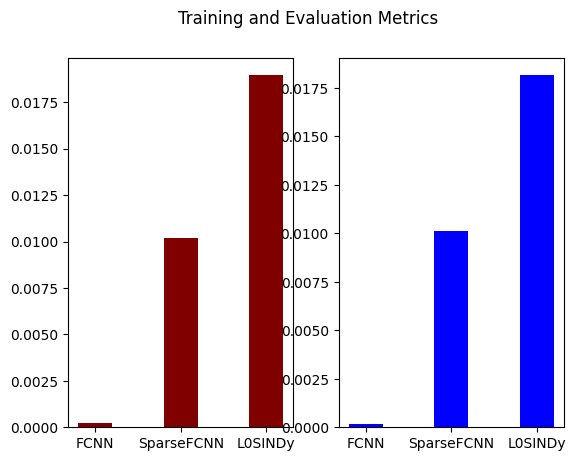

In [8]:
# creating the plots
import matplotlib.pyplot as plt
import os

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training and Evaluation Metrics')

data_train = {'FCNN': metrics_fcnn[0], 'SparseFCNN': metrics_sparsefcnn[0], 'L0SINDy': metrics_l0sindy[0]}
methods_train = list(data_train.keys())
values_train = list(data_train.values())

# creating the bar plot
ax1.bar(methods_train, values_train, color='maroon', width=0.4)

data_eval = {'FCNN': metrics_fcnn[2], 'SparseFCNN': metrics_sparsefcnn[2], 'L0SINDy': metrics_l0sindy[2]}
methods_eval = list(data_eval.keys())
values_eval = list(data_eval.values())

ax2.bar(methods_eval, values_eval, color='blue', width=0.4)

save_dir = "figures"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig.savefig('figures/LearningDynamics.png', dpi=300)